In [2650]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2651]:
from utils.UpdateDatabase import *

# Data Formatting

In [2652]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from urllib.parse import urljoin
from dotenv import load_dotenv
from datetime import *
from bson import ObjectId
import pandas as pd
import numpy as np
import requests
import random
import torch
import json
import os
load_dotenv()

True

In [2653]:
from utils.FlattenData import *
from modules.PremoAPI import *
from utils.SafeDataConverters import *

In [2654]:
api = PremoAPI()

In [2655]:
username = os.getenv("mongodb_user")
password = os.getenv("mongodb_password")

In [2656]:
from modules.database import Database
db = Database(username, password)

In [2657]:
play_data: list[dict] = api.play_data

In [2658]:
flat_out = flatten_output(db.to_json())
flat_in = flatten_input(db.to_json())

In [2659]:
# inp_df = pd.DataFrame(flat_in).sort_values(by=['order_id', 'sort_order'], ascending=True).convert_dtypes()
# inp_df['sort_order'] = inp_df.groupby(['order_id', 'product_id'])['sort_order'].transform(lambda x: x.rank(method='dense').astype(int) - 1)
# inp_df = inp_df.map(safe_to_datetime)
# inp_df.head()

In [2660]:
# out_df = pd.DataFrame(flat_out).sort_values(by=['order_id', 'sort_order'], ascending=True).convert_dtypes()
# out_df['sort_order'] = out_df.groupby(['order_id', 'product_id'])['sort_order'].transform(lambda x: x.rank(method='dense').astype(int) - 1)
# out_df = out_df.map(safe_to_datetime)
# out_df.head()

# Workspace Detection Model

In [2661]:
out_df = pd.DataFrame(flat_out).sort_values(by=['order_id', 'sort_order'], ascending=True).convert_dtypes()
out_df['sort_order'] = out_df.groupby(['order_id', 'product_id'])['sort_order'].transform(lambda x: x.rank(method='dense').astype(int) - 1)
out_df = out_df.map(safe_to_datetime)
out_df.head()

,order_id,delivery_date,order_created_at,product_id,material,color,task_title,task_duration,sort_order,workspace,start_at,end_at
3,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Vullen,3600,0,Soweco,2024-07-01 09:00:00,2024-07-01 10:00:00
2,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Tampon drukken (TB),1440,1,T2 1|2|3,2024-07-08 09:00:00,2024-07-08 09:24:00
0,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Inpakken,180,2,Inpak,2024-07-11 09:00:00,2024-07-11 09:03:00
1,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Expeditie,720,3,Expeditie,2024-07-12 09:00:00,2024-07-12 09:12:00
6,3,2024-07-24 00:00:00,2024-07-09 08:11:10,67053bafda93609bc1305299,Avant-knijper,13,Vullen,6120,0,Soweco,2024-07-10 09:00:00,2024-07-10 10:42:00


In [2662]:
out_df['duration_since_order_created'] = out_df['start_at'] - out_df['order_created_at']
out_df['duration_since_order_created'] = out_df['duration_since_order_created'].dt.total_seconds() / 60 # convert to minutes
out_df['time_until_delivery'] = out_df['delivery_date'] - out_df['start_at']
out_df['time_until_delivery'] = out_df['time_until_delivery'].dt.total_seconds() / 60 # convert to minutes
out_df.head()

,order_id,delivery_date,order_created_at,product_id,material,color,task_title,task_duration,sort_order,workspace,start_at,end_at,duration_since_order_created,time_until_delivery
3,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Vullen,3600,0,Soweco,2024-07-01 09:00:00,2024-07-01 10:00:00,-10408.850000,17608.85
2,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Tampon drukken (TB),1440,1,T2 1|2|3,2024-07-08 09:00:00,2024-07-08 09:24:00,-328.850000,7528.85
0,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Inpakken,180,2,Inpak,2024-07-11 09:00:00,2024-07-11 09:03:00,3991.150000,3208.85
1,1,2024-07-13 14:28:51,2024-07-08 14:28:51,67053bafda93609bc1305297,Katoenen draagtas gekleurd,06,Expeditie,720,3,Expeditie,2024-07-12 09:00:00,2024-07-12 09:12:00,5431.150000,1768.85
6,3,2024-07-24 00:00:00,2024-07-09 08:11:10,67053bafda93609bc1305299,Avant-knijper,13,Vullen,6120,0,Soweco,2024-07-10 09:00:00,2024-07-10 10:42:00,1488.833333,19620.00


In [2663]:
X_columns = {
    'init': ['task_title'],
    'addit': ['material', 'color', 'sort_order']
}

In [2664]:
y_columns = ['workspace', 'duration_since_order_created', 'time_until_delivery']

In [2665]:
df = out_df.copy()[['task_title', 'material', 'color', 'sort_order', 'workspace', 'duration_since_order_created', 'time_until_delivery']]
df = df.dropna()
df.head()

,task_title,material,color,sort_order,workspace,duration_since_order_created,time_until_delivery
3,Vullen,Katoenen draagtas gekleurd,06,0,Soweco,-10408.850000,17608.85
2,Tampon drukken (TB),Katoenen draagtas gekleurd,06,1,T2 1|2|3,-328.850000,7528.85
0,Inpakken,Katoenen draagtas gekleurd,06,2,Inpak,3991.150000,3208.85
1,Expeditie,Katoenen draagtas gekleurd,06,3,Expeditie,5431.150000,1768.85
6,Vullen,Avant-knijper,13,0,Soweco,1488.833333,19620.00


In [2666]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2667]:
categorical_columns = ['task_title', 'material', 'color', 'workspace']
scaler_columns = ['duration_since_order_created', 'time_until_delivery']

In [2668]:
scaler = MinMaxScaler(feature_range=(0, 1))
le = LabelEncoder()

In [2669]:
df_encoded = pd.get_dummies(df, columns=categorical_columns).astype(float)
df_encoded[scaler_columns] = scaler.fit_transform(df_encoded[scaler_columns])
df_encoded.head()

,sort_order,duration_since_order_created,time_until_delivery,task_title_DP2,task_title_Expeditie,task_title_Inpakken,task_title_LD,task_title_Sample products,task_title_Tampon drukken (TA),task_title_Tampon drukken (TB),...,color_16,color_17,color_20,workspace_Expeditie,workspace_Inpak,workspace_Sample products,workspace_Soweco,workspace_T2 1|2|3,workspace_TX 1|2 MHM,workspace_Uitbesteden
3,0.0,0.000000,0.997230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.045045,0.983347,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,2.0,0.064349,0.977397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.070784,0.975414,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.053167,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [2670]:
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
df_encoded.head()

,sort_order,duration_since_order_created,time_until_delivery,task_title_DP2,task_title_Expeditie,task_title_Inpakken,task_title_LD,task_title_Sample products,task_title_Tampon drukken (TA),task_title_Tampon drukken (TB),...,color_16,color_17,color_20,workspace_Expeditie,workspace_Inpak,workspace_Sample products,workspace_Soweco,workspace_T2 1|2|3,workspace_TX 1|2 MHM,workspace_Uitbesteden
3,0.0,0.000000,0.997230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.045045,0.983347,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,2.0,0.064349,0.977397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.070784,0.975414,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.053167,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [2671]:
# Features
X = df_encoded.drop(columns=list(df_encoded.filter(regex='^task_title_').columns)).drop(columns=['duration_since_order_created', 'time_until_delivery']).values
y = df_encoded[['duration_since_order_created', 'time_until_delivery']].values


In [2672]:
X_columns = df_encoded.drop(columns=list(df_encoded.filter(regex='^task_title_').columns)).drop(columns=['duration_since_order_created', 'time_until_delivery']).columns
y_columns = ['duration_since_order_created', 'time_until_delivery']

### Create and train the model

In [2673]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [2674]:
input_size = X.shape[1]
output_size = y.shape[1]

In [2675]:
# Hyperparameters
batch_size = 32
num_epochs = 1000
learning_rate = 0.002

In [2676]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [2677]:
class NeuralNet(Model):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        
        self.nnet = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_size,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(output_size)
        ])
        
    def call(self, x):
        return self.nnet(x)

In [2678]:
model = NeuralNet(input_size, output_size)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    loss='mse',
    metrics=['mse']
)


/Users/grafistore/Desktop/GrafiStoreMLAPI/.conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2679]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Stop training if val_loss does not improve for 3 epochs

In [2680]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val)) #, callbacks=[callback])

Epoch 1/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2974 - mse: 0.2974 - val_loss: 0.0828 - val_mse: 0.0828
Epoch 2/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 3/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 4/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 5/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 6/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 7/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 8/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 9/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/s

In [2681]:
import matplotlib.pyplot as plt

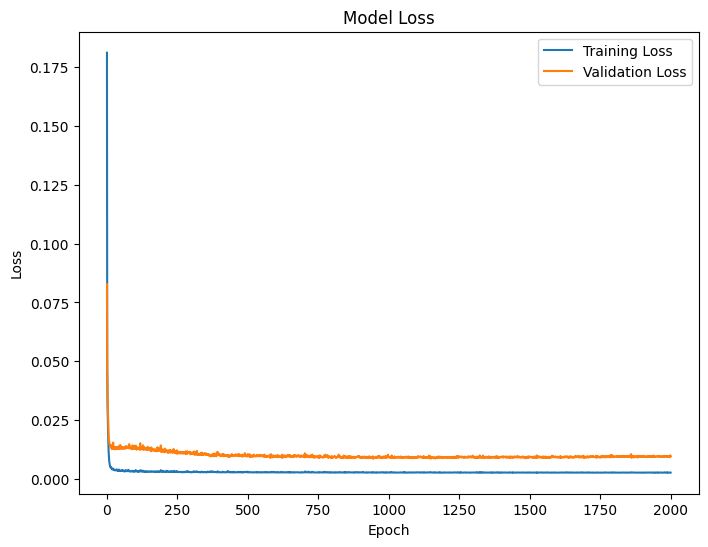

In [2682]:
# Plot total loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predict

In [2683]:
from random import randint

In [2684]:
sample_index = randint(0, X.shape[0])  # Change this index to get different samples

In [2685]:
# Get a sample from the dataset
sample_input_enc = X[sample_index].reshape(1, -1)
sample_correct_target = y[sample_index].reshape(1, -1)

In [2686]:
sample_correct_target = pd.DataFrame(sample_correct_target, columns=y_columns)

In [2687]:
sample_input = pd.DataFrame(sample_input_enc, columns=X_columns)

In [2688]:
sample_correct_target[['duration_since_order_created', 'time_until_delivery']] = scaler.inverse_transform(sample_correct_target[['duration_since_order_created', 'time_until_delivery']])

In [2689]:
forward = model.predict(sample_input_enc, verbose=0)

In [2690]:
pred = scaler.inverse_transform(forward)
pred = pd.DataFrame(pred, columns=y_columns)
pred

,duration_since_order_created,time_until_delivery
0,27716.509766,-26357.705078


In [2691]:
sample_correct_target

,duration_since_order_created,time_until_delivery
0,21779.15,-20940.233333
